In [ ]:
import os

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from diffrax import Dopri5, ODETerm, SaveAt, diffeqsolve
from util import sparse_dot

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".75"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
columns = pd.read_csv("column_assignment.csv")
(columns.type == "R8").sum()
columns.query('type in ["R1-6", "R7", "R8"]')
# columns.type.unique()

,root_id,hemisphere,type,column_id,x,y,p,q
7635,720575940610510275,right,R7,1,-6,13,12,1
7636,720575940640795043,right,R7,3,6,-12,-12,0
7637,720575940614528749,right,R7,5,-1,16,9,7
7638,720575940628593320,right,R7,6,-2,-4,0,-4
7639,720575940616833211,right,R7,7,-6,-6,3,-9
...,...,...,...,...,...,...,...,...
8699,720575940635717786,right,R8,770,5,4,-3,7
8700,720575940634572384,right,R8,772,1,12,5,7
8701,720575940623642723,right,R8,773,5,-19,-15,-4
8702,720575940622659422,right,R8,774,-8,6,11,-5


In [3]:
neurons = pd.read_csv("visual_neuron_ids.csv")
(neurons.type == "R8").sum()

655

In [ ]:
neuron_ids = pd.read_csv("visual_neuron_ids.csv")
neuron_ids.query('type in ["R8", "R7", "R1-6"]')

,root_id,type,category,side
19466,720575940601049097,R1-6,OL intrinsic,right
19467,720575940605160550,R1-6,OL intrinsic,right
19468,720575940605444576,R1-6,OL intrinsic,right
19469,720575940605515744,R1-6,OL intrinsic,right
19470,720575940605547488,R1-6,OL intrinsic,right
...,...,...,...,...
24212,720575940656074145,R8,OL intrinsic,right
24213,720575940656086177,R8,OL intrinsic,right
24214,720575940659591297,R8,OL intrinsic,right
24215,720575940661201025,R8,OL intrinsic,right


In [ ]:
column_data = np.load("moving_mnist_vision.npy")
input_neuron_ids = pd.read_csv("visual_column_assignment.csv")

In [6]:
column_data.shape

(20, 10000, 796)

In [ ]:
lookup = dict(zip(neuron_ids["root_id"].to_list(), neuron_ids.index))
# input_projection = np.eye(len(neurons))[:, input_neuron_ids["root_id"].map(lookup).to_numpy()]
input_projection = scipy.sparse.coo_matrix(
    np.eye(len(neurons))[:, input_neuron_ids["root_id"].map(lookup).to_numpy()]
)
column_ids = input_neuron_ids["column_ids"] - 1

In [9]:
input_projection.shape

(47521, 4751)

In [10]:
column_data.shape
column_ids.to_numpy()

array([187, 189, 354, ...,  36, 700, 693])

In [ ]:
arr = np.load("visual_adj_matrix_20240711.npy")
arr = scipy.sparse.coo_matrix(arr)
# scipy.sparse.save_npz('visual_adj_matrix_sparse.npz', arr)

In [21]:
column_data[jnp.array(1, int)]
type(column_data)

numpy.ndarray

In [ ]:
N = len(neuron_ids)


def forward(t, y, args):
    W_row = args["W_row"]
    W_col = args["W_col"]
    W_data = args["W_data"]
    input_row = args["input_row"]
    input_col = args["input_col"]
    input_data = args["input_data"]
    column_data = args["column_data"]
    column_ids = args["column_ids"]

    bias = args["bias"]
    leak = args["leak"]
    tau = args["tau"]
    return (
        1
        / tau
        * (
            -y * leak
            + bias
            + sparse_dot(W_row, W_col, W_data, y, N)
            + 10
            * sparse_dot(
                input_row,
                input_col,
                input_data,
                column_data[0, jnp.array((t * 10), int), column_ids],
                N,
            )
        )
    )


term = ODETerm(forward)
solver = Dopri5()
y0 = jax.random.normal(jax.random.PRNGKey(0), (N,)) * 0.01

In [22]:
input_projection.shape

(47521, 4751)

In [ ]:
# forward(0, y0, {"W": W, "bias": 0.1, "tau": 1.0})
sol = diffeqsolve(
    term,
    solver,
    t0=0.0,
    t1=10.0,
    dt0=0.01,
    y0=y0,
    saveat=SaveAt(ts=jnp.linspace(0, 1, 20)),
    args={
        "W_row": arr.row,
        "W_col": arr.col,
        "W_data": arr.data / 100,
        "bias": 0.1,
        "tau": 10.0,
        "leak": 20.0,
        "input_row": input_projection.row,
        "input_col": input_projection.col,
        "input_data": input_projection.data,
        "column_data": column_data,
        "column_ids": column_ids.to_numpy(),
    },
)

/home/sunny/anaconda3/envs/dros/lib/python3.9/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/sunny/anaconda3/envs/dros/lib/python3.9/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/sunny/anaconda3/envs/dros/lib/python3.9/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [ ]:
ids = input_neuron_ids["root_id"].map(lookup).to_numpy()

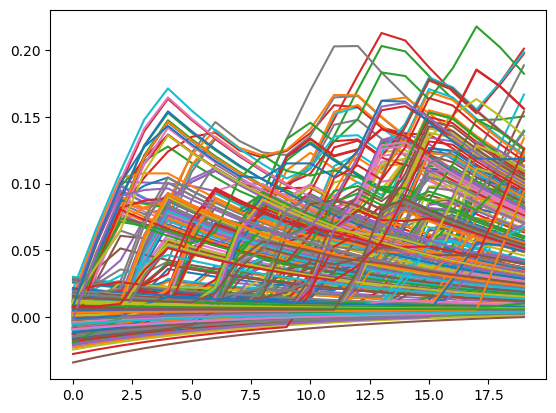

In [44]:
plt.plot(sol.ys[:, ids[::10]]);